Import modules

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import keras.backend as K
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc,roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Activation
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam


Input data

In [7]:
# Generate data
train_dir='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/train/'
test_dir='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/test/'
class_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,
                                rotation_range=5,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                #zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')
valid_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

train_dataset=train_datagen.flow_from_directory(directory='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/train/',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64)

valid_dataset=valid_datagen.flow_from_directory(directory='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/test/',
                                               target_size=(48,48),
                                               class_mode='categorical',
                                               batch_size=64)

test_dataset=test_datagen.flow_from_directory(directory='C:/Users/Admin/Desktop/FER-DL-master/Datasets/archive (1)/test/',
                                             target_size=(48,48),
                                             batch_size=64,
                                             class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Building model

In [8]:
model_1=VGG16(input_shape=(48,48,3),include_top=False,weights='imagenet')

In [9]:
# Freezing layers
for layer in model_1.layers[:-4]:
    layer.trainable=False

#Buliding model
model_vgg=Sequential()
model_vgg.add(model_1)
model_vgg.add(Dropout(0.5))
model_vgg.add(Flatten())
model_vgg.add(BatchNormalization())
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dense(7,activation='softmax'))

In [10]:
# Model Summary
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [11]:
# Training
check_point=ModelCheckpoint('vgg_model.h5')
model_vgg.compile(optimizer='Adam',loss='categorical_crossentropy',metrics='accuracy')
vgg_history=model_vgg.fit(train_dataset,validation_data=valid_dataset,epochs=50,verbose=1,callbacks=[check_point])

Epoch 1/50


359/359 [==============================] - ETA: 0s - loss: 1.9637 - accuracy: 0.2007

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 670s 2s/step - loss: 1.9637 - accuracy: 0.2007 - val_loss: 1.8238 - val_accuracy: 0.2471
Epoch 2/50
359/359 [==============================] - 304s 847ms/step - loss: 1.8260 - accuracy: 0.2423 - val_loss: 1.7811 - val_accuracy: 0.2899
Epoch 3/50
359/359 [==============================] - 268s 746ms/step - loss: 1.7874 - accuracy: 0.2649 - val_loss: 1.7879 - val_accuracy: 0.2244
Epoch 4/50
359/359 [==============================] - 272s 757ms/step - loss: 1.8028 - accuracy: 0.2514 - val_loss: 1.7765 - val_accuracy: 0.2512
Epoch 5/50
359/359 [==============================] - 271s 754ms/step - loss: 1.7691 - accuracy: 0.2671 - val_loss: 1.7146 - val_accuracy: 0.2995
Epoch 6/50
359/359 [==============================] - 274s 764ms/step - loss: 1.7472 - accuracy: 0.2867 - val_loss: 1.7580 - val_accuracy: 0.2643
Epoch 7/50
359/359 [==============================] - 268s 746ms/step - loss: 1.7287 - accuracy: 0.3029 - val_loss: 1.7514 - val_accuracy:

In [12]:
# Save model
model_vgg.save('vgg_model.h5')

Evaluation

In [13]:
# Evaluating
vgg_acc=model_vgg.evaluate(test_dataset,verbose=0)[1]
preds=model_vgg.predict(test_dataset)
y_preds=np.argmax(preds,axis=1)
y_test=np.array(test_dataset.labels)

acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

113/113 [==============================] - 45s 396ms/step
Accuracy: 0.19281136806910001
Precision: 0.16883104873193994
Recall: 0.19281136806910001
F1 Score: 0.16097907803960793


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


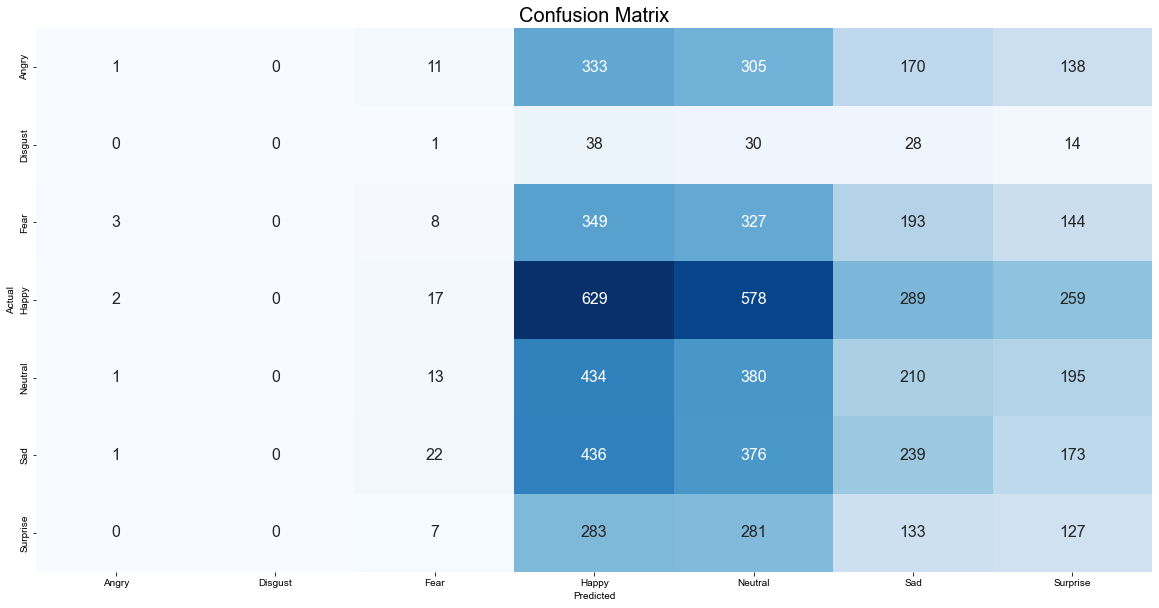

In [14]:
# Confution matrix
cm_data_vgg=confusion_matrix(y_test,y_preds)
cm_vgg=pd.DataFrame(cm_data_vgg,columns=class_labels,index=class_labels)
cm_vgg.index.name="Actual"
cm_vgg.columns.name="Predicted"
plt.figure(figsize=(20,10))
plt.title('Confusion Matrix',fontsize=20)
sn.set(font_scale=1.2)
sn.set(font_scale=1.2)
ax_vgg=sn.heatmap(cm_vgg,cbar=False,cmap="Blues",annot=True,annot_kws={"size":16},fmt='g')

In [15]:
# Classification report
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.12      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.10      0.01      0.01      1024
           3       0.25      0.35      0.29      1774
           4       0.17      0.31      0.22      1233
           5       0.19      0.19      0.19      1247
           6       0.12      0.15      0.14       831

    accuracy                           0.19      7178
   macro avg       0.14      0.15      0.12      7178
weighted avg       0.17      0.19      0.16      7178



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

ROC AUC score: 0.5967433038496756


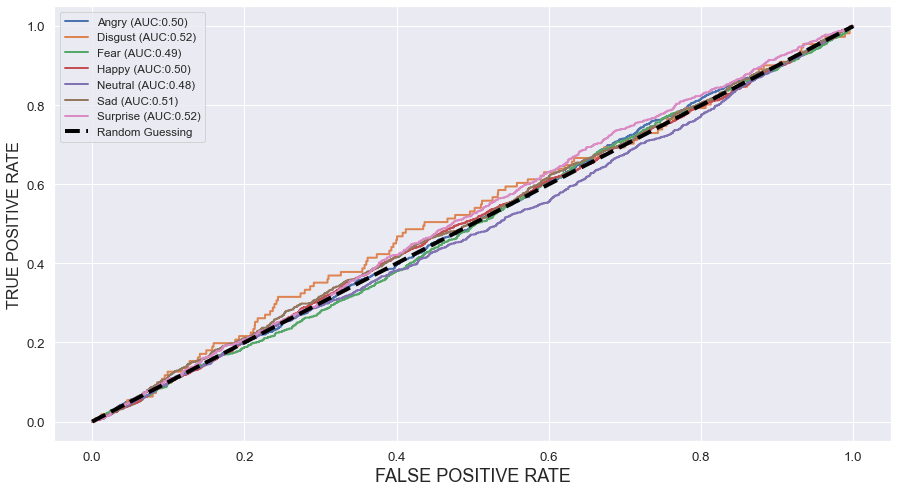

In [16]:
# Multiclass ROC curve
fig,c_ax=plt.subplots(1,1,figsize=(15,8))

def multiclass_roc_auc_score1(y_test,y_preds,average="macro"):
    lb=LabelBinarizer()
    lb.fit(y_test)
    y_test=lb.transform(y_test)
    for(idx,c_label) in enumerate(class_labels):
        fpr,tpr,thresholds=roc_curve(y_test[:,idx].astype(int),y_preds[:,idx])
        c_ax.plot(fpr,tpr,lw=2,label='%s (AUC:%0.2f)'%(c_label,auc(fpr,tpr)))
    c_ax.plot(fpr,fpr,'black',linestyle='dashed',lw=4,label='Random Guessing')
    return roc_auc_score(y_test,y_preds,average=average)

print('ROC AUC score:',multiclass_roc_auc_score1(y_test,preds,average='micro'))
plt.xlabel('FALSE POSITIVE RATE',fontsize=18)
plt.ylabel('TRUE POSITIVE RATE',fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

In [1]:
# Plotting result
plt.plot(vgg_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined